# Load in the Labeled Test Data to Evaluate the Model Performance

From Crossing/Null use the Test folder

From Present/Missing use the Valid Folder

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64

In [27]:
# PATHS
SAGEMAKER_REPO_PATH = Path(r'/home/ec2-user/SageMaker/classify-streetview/')

# Data
data_model5_path = Path(os.path.join(SAGEMAKER_REPO_PATH, 'images-cross-null'))
data_model6_path = Path(os.path.join(SAGEMAKER_REPO_PATH, 'images-missing-present-2split'))

# Model name without pth
model5_path = os.path.join(SAGEMAKER_REPO_PATH, 'images-cross-null/models/varlr-resnet34-crossnull')
model6_path = os.path.join(SAGEMAKER_REPO_PATH, 'images-missing-present-2split/models/varlr-missing-present')

# Load the Crossing/Null Data and Model

In [13]:
print(data_path)
data_path.ls()

/home/ec2-user/SageMaker/classify-streetview/images-cross-null


[PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-cross-null/train'),
 PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-cross-null/.ipynb_checkpoints'),
 PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-cross-null/valid'),
 PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-cross-null/models'),
 PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-cross-null/test')]

In [29]:
# Transforms applied 
tfms = get_transforms(do_flip=False)

test_model5_data = ImageDataBunch.from_folder(data_model5_path, train = 'train', valid = 'test', test = None, ds_tfms = tfms, size = 224,   bs=bs).normalize()
test_model5_data.classes

['0_crossing', '1_null']

In [33]:
test_model5_data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (4011 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_crossing,0_crossing,0_crossing,0_crossing,0_crossing
Path: /home/ec2-user/SageMaker/classify-streetview/images-cross-null;

Valid: LabelList (737 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_crossing,0_crossing,0_crossing,0_crossing,0_crossing
Path: /home/ec2-user/SageMaker/classify-streetview/images-cross-null;

Test: None>

# Load Model

In [35]:
learn = cnn_learner(data, models.resnet34, metrics = [error_rate, Precision(0)])
learn.load(model5_path)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Learner(data=ImageDataBunch;

Train: LabelList (4011 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_crossing,0_crossing,0_crossing,0_crossing,0_crossing
Path: /home/ec2-user/SageMaker/classify-streetview/images-cross-null;

Valid: LabelList (737 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_crossing,0_crossing,0_crossing,0_crossing,0_crossing
Path: /home/ec2-user/SageMaker/classify-streetview/images-cross-null;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv

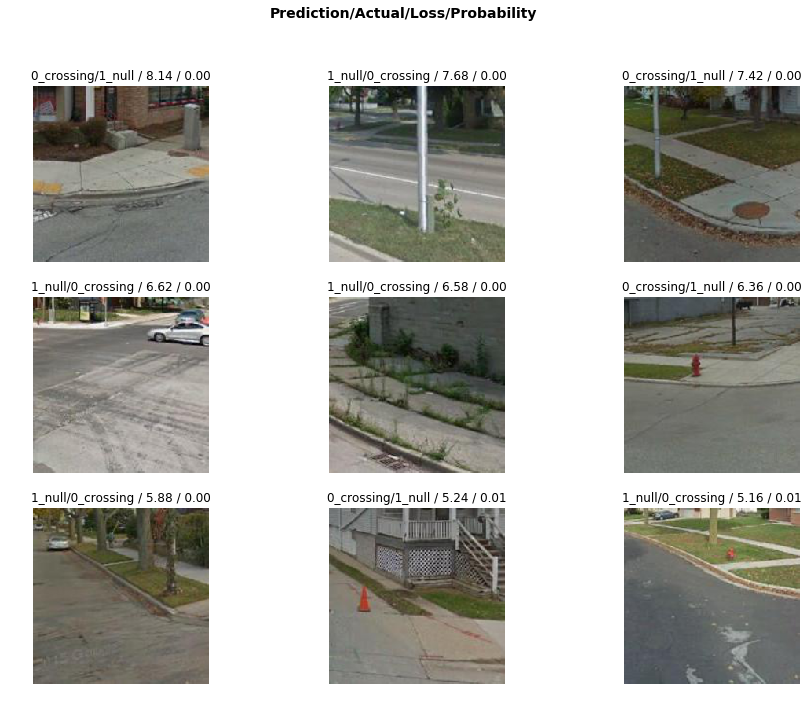

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

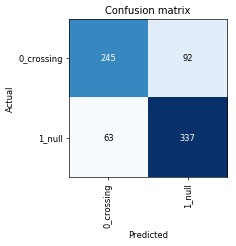

In [38]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

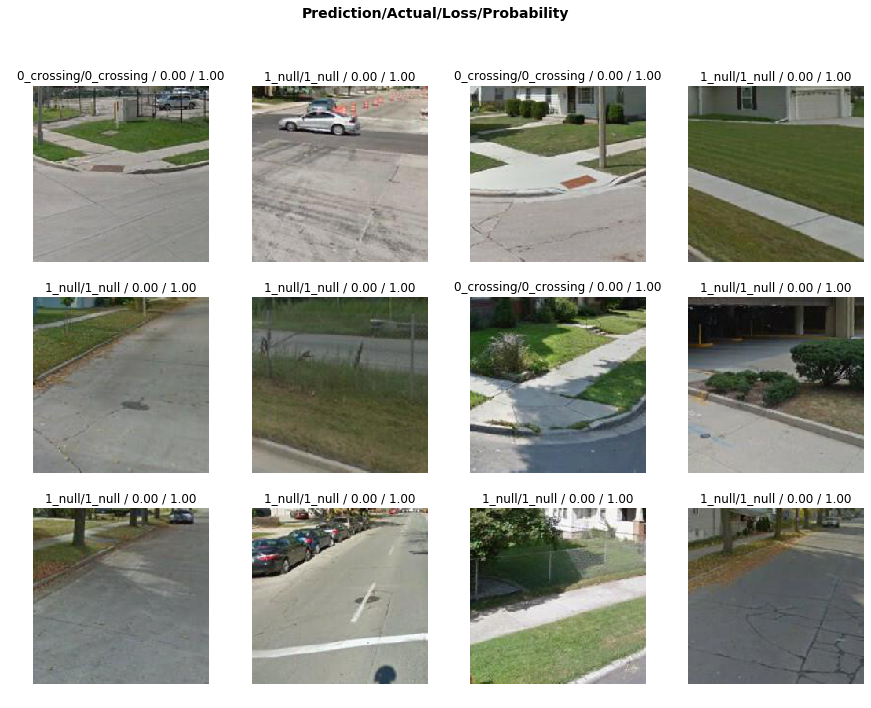

In [40]:
interp.plot_top_losses(12, largest = False, figsize=(15,11))

In [ ]:
#https://forums.fast.ai/t/saving-get-preds-results-to-excel-with-file-names/46872/2


testprobs,labels = learn.get_preds(ds_type=DatasetType.Test)
testdf = pd.DataFrame(dict(id=data.test_ds.x._relative_item_paths(), label=0))
testdf['label'] = testprobs.numpy()
testdf['id'] = testdf['id'].apply(lambda fp: Path(fp).stem)
testdf.to_csv(SUBM/'submissionFile.csv', index=False, float_format='%.9f')